# Bollingerband Strategy

In [22]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])
# pd.set_option('display.max_seq_items', None)
# pd.set_option('display.max_rows', None)

In [23]:
def bollinger_band(price_df, n, sigma):
    bollinger_band = price_df.copy()
    bollinger_band['center'] = price_df['Close'].rolling(window=n).mean()    # center moving average
    bollinger_band['upper band'] = bollinger_band['center'] + sigma*price_df['Close'].rolling(window=n).std()    # upper band
    bollinger_band['lower band'] = bollinger_band['center'] - sigma*price_df['Close'].rolling(window=n).std()    # lower band
    return bollinger_band

In [24]:
def create_trade_book(sample):
    book = sample[['Close']].copy()
    book['trade'] = ''
    book['buy_signal_score'] = 0.0
    book['sell_signal_score'] = 0.0
    return book

def returns(book):
    # long only
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index[1:]:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
            buy = book.loc[i, 'Close']
            print('매수일 : ', i.strftime('%Y-%m-%d'), '매수가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell = book.loc[i, 'Close']
            rtn = (sell - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            print('매도일 : ', i.strftime('%Y-%m-%d'), '매도가격 : ', sell, ' | return:', round(rtn, 4))

        if book.loc[i, 'trade'] == '':
            buy = 0.0
            sell = 0.0

        acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn
        book.loc[i, 'acc return'] = acc_rtn

    print('Accumulated return :', round(acc_rtn, 4))
    return(round(acc_rtn, 4))

In [25]:
def tradings(sample, book):
    for i in sample.index[1:]:
        book.loc[i, 'buy_signal_score'] = (sample.loc[i, 'center'] - sample.loc[i, 'Close'])/(sample.loc[i, 'upper band'] - sample.loc[i, 'lower band'])
        book.loc[i, 'sell_signal_score'] = (sample.loc[i, 'Close'] - sample.loc[i, 'center'])/(sample.loc[i, 'upper band'] - sample.loc[i, 'lower band'])
        if book.shift(1).loc[i, 'trade'] == 'buy':
            if book.loc[i, 'sell_signal_score'] >= 0.5:
                book.loc[i, 'trade'] = ''
                # plt.axvline(i, linewidth=1, color='C0', linestyle='--', label = 'sell')
            else:
                book.loc[i, 'trade'] = 'buy'
                             
        else:
            if book.loc[i, 'buy_signal_score'] >= 0.5:
                book.loc[i, 'trade'] = 'buy'
                # plt.axvline(i, linewidth=1, color='C3', linestyle='--', label = 'buy')
    return(book)

In [26]:
dataframe = fdr.DataReader('005930', '2000')     # Index is already 'Date'

In [27]:
dataframe

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-01-04,6000,6110,5660,6110,1483967,0.148496
2000-01-05,5800,6060,5520,5580,1493604,-0.086743
2000-01-06,5750,5780,5580,5620,1087810,0.007168
2000-01-07,5560,5670,5360,5540,806195,-0.014235
2000-01-10,5600,5770,5580,5770,937615,0.041516
...,...,...,...,...,...,...
2021-10-08,72300,72400,71500,71500,14043287,-0.001397
2021-10-12,70700,70900,68700,69000,31001484,-0.034965
2021-10-13,68700,69600,68300,68800,24172015,-0.002899


            Close
Date             
2000-01-04   6110
2000-01-05   5580
2000-01-06   5620
2000-01-07   5540
2000-01-10   5770


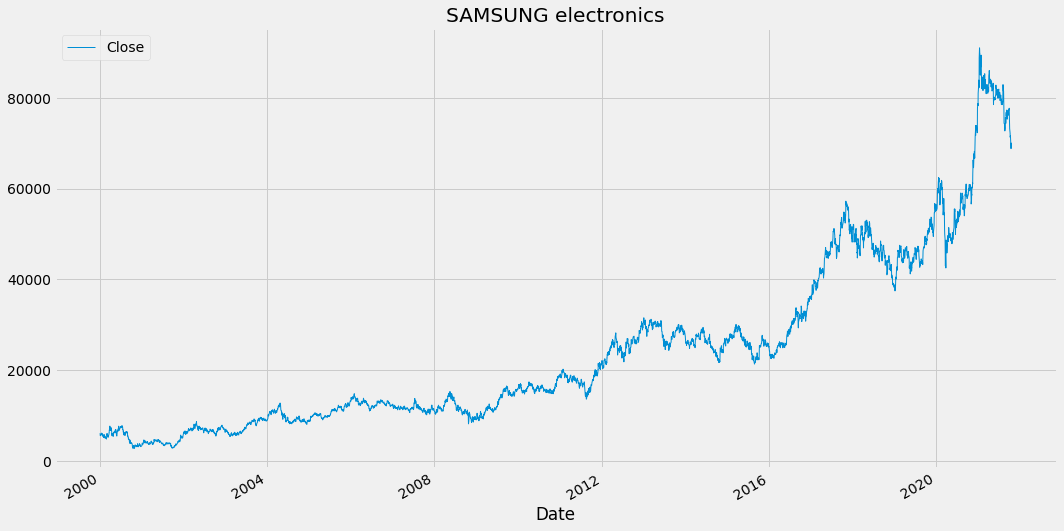

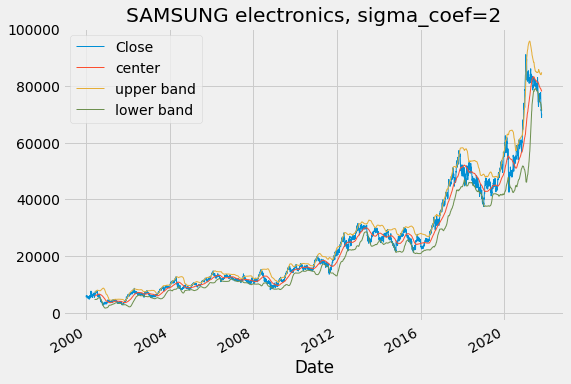

In [37]:
w_size = 100      # size of window
sigma_coef = 2     # number multiplied with sigma
base_date = '2000-05-01' # Date started trade


price_df = dataframe.loc[:, ['Close']].copy()    # Extract 'Close' column, 'fdr' offer Adjusted Close as 'Close'
price_df.plot(figsize=(16, 9), title='SAMSUNG electronics', linewidth=1.0)
print(price_df.head())

bollinger = bollinger_band(price_df, w_size, sigma_coef)
bollinger.plot(figsize=(8, 6), title='SAMSUNG electronics, sigma_coef=2', linewidth=1.0)
plt.legend()
sample = bollinger.loc[base_date:]



In [38]:
book = create_trade_book(sample)
book = tradings(sample, book)
print(book.head(5))
print(book.tail(5))
print(returns(book))
print('Last Date: ',book.index[-1].strftime('%Y-%m-%d'))
print('buy_signal_score: ', book.loc[book.index[-1], 'buy_signal_score'])
print('sell_signal_score: ', book.loc[book.index[-1], 'sell_signal_score'])


            Close trade  buy_signal_score  sell_signal_score
Date                                                        
2000-05-02   6280                     0.0                0.0
2000-05-03   6180                     NaN                NaN
2000-05-04   6180                     NaN                NaN
2000-05-08   6560                     NaN                NaN
2000-05-09   6370                     NaN                NaN
            Close trade  buy_signal_score  sell_signal_score
Date                                                        
2021-10-08  71500   buy          0.598521          -0.598521
2021-10-12  69000   buy          0.767236          -0.767236
2021-10-13  68800   buy          0.740080          -0.740080
2021-10-14  69400   buy          0.660564          -0.660564
2021-10-15  70100   buy          0.583792          -0.583792
매수일 :  2000-09-05 매수가격 :  5150
매도일 :  2001-04-19 매도가격 :  4700  | return: 0.9126
매수일 :  2001-07-09 매수가격 :  3420
매도일 :  2001-11-14 매도가격 :  4300  | r

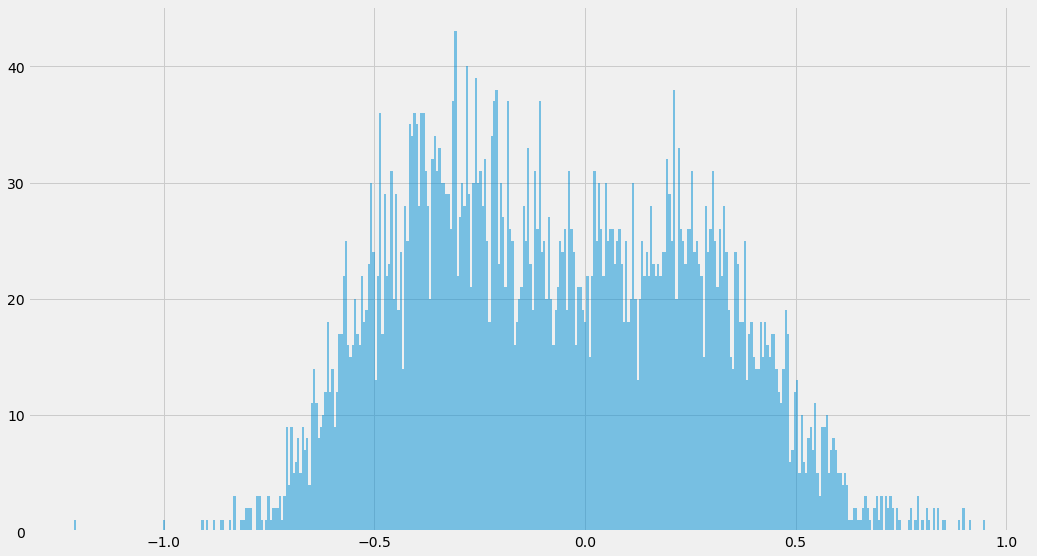

In [39]:

plt.rcParams["figure.figsize"] = (16,9)
plt.hist(book.loc[:, 'buy_signal_score'], bins=400, alpha=0.5, histtype='bar')
plt.show()